In [55]:
import numpy as np
import pandas as pd
from datetime import date
import os

# Custom Libraries -->
%load_ext autoreload
%autoreload 2
from src.portfolio import Portfolio
from src.simulation import MonteCarloSimulation
from src.tradier import Tradier

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
%load_ext dotenv
%dotenv
access_token = os.environ.get("access_token")

SYMBOL = "TSLA"
START_DATE = "2015-01-01"
END_DATE = "2023-12-30"

tradier = Tradier(access_token)

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [57]:
daily_std = tradier.getVolatility(SYMBOL, START_DATE, END_DATE)
print("Daily STD:", daily_std)

price = tradier.getMarketPrice(SYMBOL)
print("Price:", price)

Daily STD: 2.333191344184291
Price: 240.45


In [58]:
expiration_dates = tradier.getSymbolExpirationDates(SYMBOL)
print("Expiration Dates:", expiration_dates)

expiration = expiration_dates[8]
today = date.today()
NUM_OF_DAYS = np.busday_count(today, expiration)

Expiration Dates: ['2024-01-12', '2024-01-19', '2024-01-26', '2024-02-02', '2024-02-09', '2024-02-16', '2024-02-23', '2024-03-15', '2024-04-19', '2024-05-17', '2024-06-21', '2024-07-19', '2024-09-20', '2025-01-17', '2025-06-20', '2025-09-19', '2025-12-19', '2026-01-16', '2026-06-18']


In [59]:
json_response = tradier.getOptionChain(SYMBOL, expiration)

call_strikes = [entry['strike'] if entry['option_type'] == "call" else None for entry in json_response['options']['option']]
call_bids = [entry['ask'] if entry['option_type'] == "call" else None for entry in json_response['options']['option']]
call_asks = [entry['bid'] if entry['option_type'] == "call" else None for entry in json_response['options']['option']]

put_strikes = [entry['strike'] if entry['option_type'] == "put" else None for entry in json_response['options']['option']]
put_bids = [entry['bid'] if entry['option_type'] == "put" else None for entry in json_response['options']['option']]
put_asks = [entry['ask'] if entry['option_type'] == "put" else None for entry in json_response['options']['option']]

option_data = {
    'call_strikes': call_strikes,
    'call_bids': call_bids,
    'call_asks': call_asks,
    'put_strikes': put_strikes,
    'put_bids': put_bids,
    'put_asks': put_asks
}

In [60]:
std = daily_std * np.sqrt(NUM_OF_DAYS)
print("Adjusted Standard Deviation:", std)

STD_WIDTH = 3
prices = np.arange(price - STD_WIDTH * std, price + STD_WIDTH * std, 1)

Adjusted Standard Deviation: 19.934795583253027


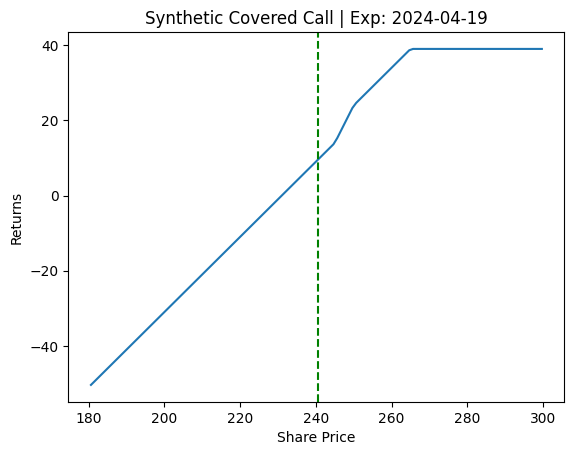

In [61]:
covered_call_strat = Portfolio(option_data, [
    # ATM Call PUT
    (price, expiration, 'Call', 'Long'),
    
    # ATM SHORT PUT
    (price, expiration, 'Put', 'Short'),
    
    # OTM SHORT CALL
    (price + std, expiration, 'Call', 'Short'),
])

# covered_call_strat.log()
covered_call_strat.draw(prices, price, std, expiration, showMarkers=True)

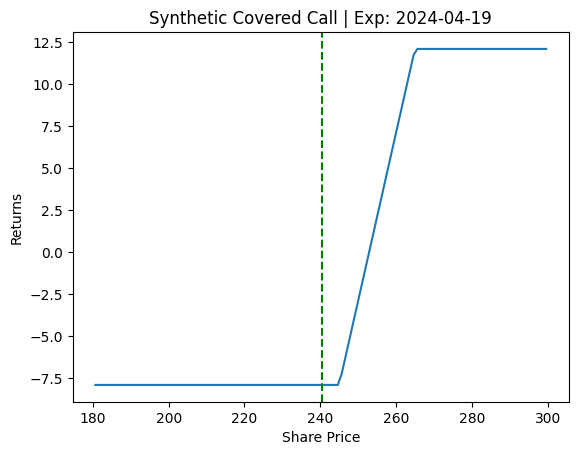

In [62]:
long_call = Portfolio(option_data, [
    (price, expiration, 'Call', 'Long'),
    (price+std, expiration, 'Call', 'Short'),
])

long_call.draw(prices, price, std, expiration, showMarkers=True)

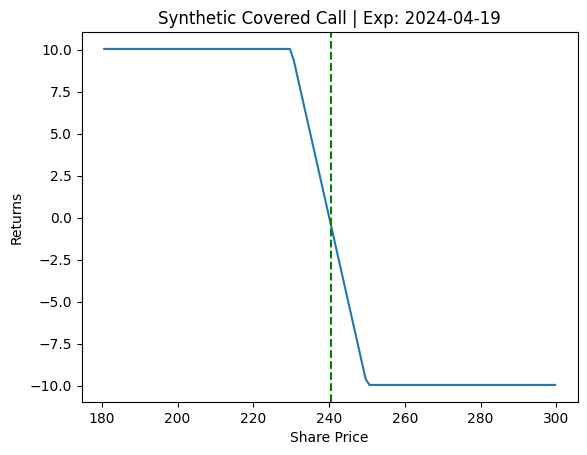

In [63]:
bear_put_spread = Portfolio(option_data, [
    (price, expiration, 'Put', 'Long'),
    (price-std, expiration, 'Put', 'Short'),
])

bear_put_spread.draw(prices, price, std, expiration, showMarkers=True)

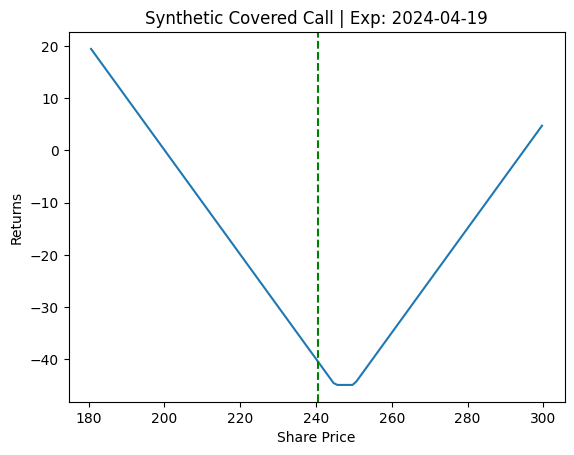

In [64]:
long_straddle = Portfolio(option_data, [
    (price, expiration, 'Call', 'Long'),
    (price, expiration, 'Put', 'Long'),
])

long_straddle.draw(prices, price, std, expiration, showMarkers=True)

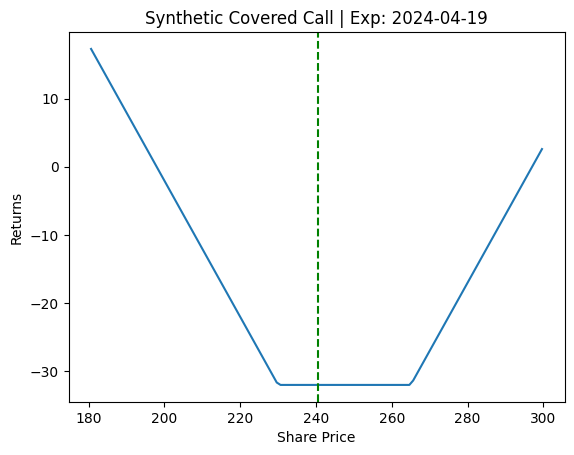

In [65]:
long_strangle = Portfolio(option_data, [
    (price+std, expiration, 'Call', 'Long'),
    (price-std, expiration, 'Put', 'Long'),
])

long_strangle.draw(prices, price, std, expiration, showMarkers=True)

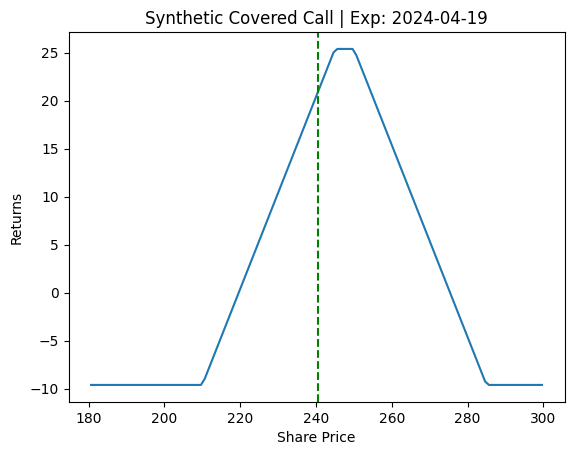

In [66]:
long_call_butterfly_spread = Portfolio(option_data, [
    (price+2*std, expiration, 'Call', 'Long'),
    (price, expiration, 'Call', 'Short'),
    
    (price-2*std, expiration, 'Put', 'Long'),
    (price, expiration, 'Put', 'Short'),
])

long_call_butterfly_spread.draw(prices, price, std, expiration, showMarkers=True)

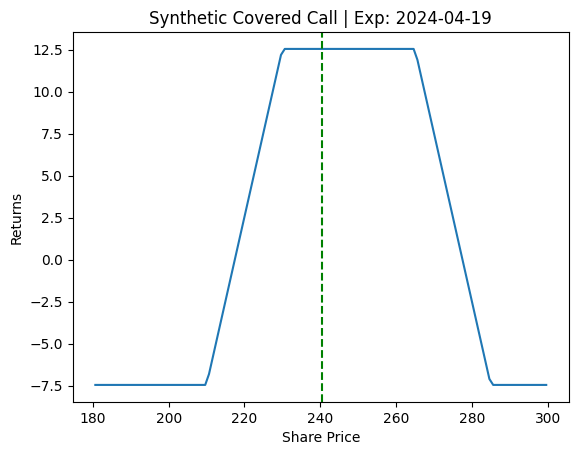

In [67]:
iron_condor_spread = Portfolio(option_data, [
    (price-std, expiration, 'Put', 'Short'),
    (price-2*std, expiration, 'Put', 'Long'),

    (price+std, expiration, 'Call', 'Short'),
    (price+2*std, expiration, 'Call', 'Long'),
    
])

iron_condor_spread.draw(prices, price, std, expiration, showMarkers=True)

Portfolio:
Cost per trade:  105.39999999999999
Strike: 225.0 Premium: 33.6 Type: Call Side: Long
Strike: 230.0 Premium: 16.95 Type: Put Side: Short
Strike: 270.0 Premium: 39.75 Type: Put Side: Long
Strike: 265.0 Premium: 15.1 Type: Call Side: Short


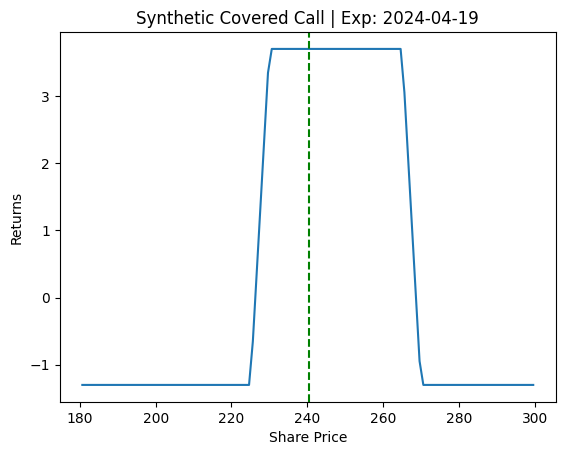

In [68]:
box_spread = Portfolio(option_data, [
    (price-std, expiration, 'Call', 'Long'),
    (price-std, expiration, 'Put', 'Short'),
    
    (price+std, expiration, 'Put', 'Long'),
    (price+std, expiration, 'Call', 'Short'),
])

box_spread.log()
box_spread.draw(prices, price, std, expiration, showMarkers=True)